# Assignment 2 - Machine Learning
**Project:** Project 1 - Classify Images of Road Traffic Signs

**Group Name:** Dan & Ethan
| Name               | Student Number |
|--------------------|----------------|
| Daniel Schellekens | s3900792       |
| Ethan Rayner       | s3902240       |

In [1]:
IMAGES_FILE = "images.csv"
TEST_TRAIN_SPLIT = 0.2

from models.utils import prep_data

data, train_data, val_data = prep_data(IMAGES_FILE, TEST_TRAIN_SPLIT)
data.head()

Training set: 2959 rows
Validation set: 740 rows


,path,shape,type
0,images\diamond\rightofway\00032_00000.png,diamond,rightofway
1,images\diamond\rightofway\00032_00001.png,diamond,rightofway
2,images\diamond\rightofway\00032_00002.png,diamond,rightofway
3,images\diamond\rightofway\00037_00000.png,diamond,rightofway
4,images\diamond\rightofway\00037_00001.png,diamond,rightofway


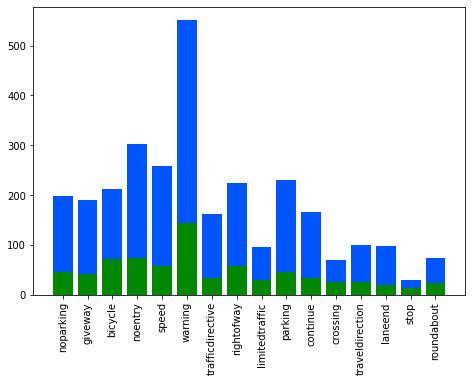

In [2]:
CLASS_COLUMN = "type" 

from models.eda import classes_histogram

classes_histogram(train_data, val_data, CLASS_COLUMN)

Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


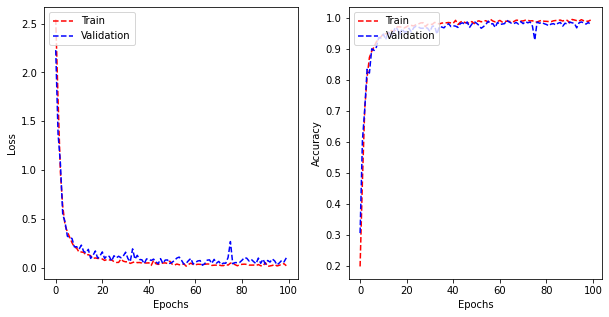

In [3]:
IMAGE_SIZE = 28
BATCH_SIZE = 32
EPOCHS = 100

import models.vgg as vgg
from models.utils import history_graph
from models.utils import create_generator

vgg_train_images = create_generator(train_data, CLASS_COLUMN, IMAGE_SIZE, BATCH_SIZE)
vgg_val_images = create_generator(val_data, CLASS_COLUMN, IMAGE_SIZE, BATCH_SIZE)
vgg_model, vgg_history = vgg.fit_model(data, CLASS_COLUMN, vgg_train_images, vgg_val_images, IMAGE_SIZE, EPOCHS)
history_graph(vgg_history)

Found 80 validated image filenames belonging to 16 classes.
F1 Scores (per class):
    bicycle:             100.0
    continue:            100.0
    crossing:            100.0
    giveway:             100.0
    laneend:             100.0
    limitedtraffic:      90.1
    noentry:             100.0
    noparking:           86.8
    parking:             100.0
    rightofway:          100.0
    roundabout:          82.2
    speed:               75.7
    stop:                100.0
    trafficdirective:    28.6
    traveldirection:     56.5
Mean F1 score: 87.6


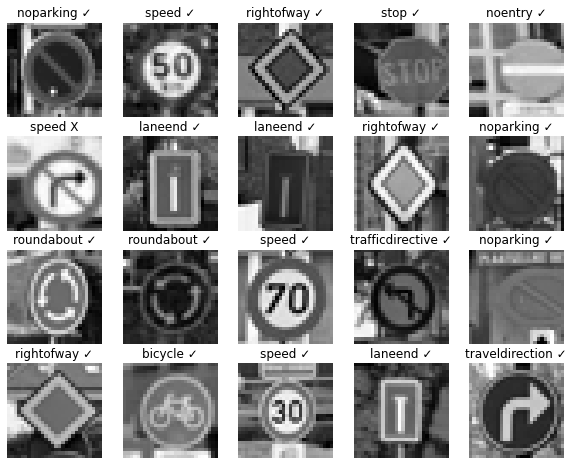

In [4]:
NUM_TO_VISUALIZE = 20
NUM_TO_SCORE = 500
IMAGES_FILE = "test-images.csv"

import numpy as np
from models.test import create_test_generator
from models.test import show_visual_results
# from models.test import score_accuracy
from models.test import score_f1

vgg_test_images = create_test_generator(IMAGES_FILE, CLASS_COLUMN, IMAGE_SIZE, 1)
show_visual_results(vgg_model, vgg_test_images, NUM_TO_VISUALIZE)

# vgg_test_accuracy = score_accuracy(vgg_model, vgg_test_images, NUM_TO_SCORE)
# print("Accuracy on {} images: {:.1f}%".format(NUM_TO_SCORE, vgg_test_accuracy * 100))

f1_scores = score_f1(vgg_model, vgg_test_images, NUM_TO_SCORE)
print("F1 Scores (per class):")
for k in f1_scores:
    v = f1_scores[k]
    print("    {:<20} {:.1f}".format(k + ":", v * 100))

f1_scores_vals = [f1_scores[k] for k in f1_scores]
print("Mean F1 score: {:.1f}".format(np.mean(f1_scores_vals) * 100))